In [ ]:
import jax, jax.numpy as jnp, jax.random as jr 
import tensorflow_probability.substrates.jax.distributions as tfd
from chainconsumer import ChainConsumer
import matplotlib.pyplot as plt

from make_fields import simulator

key = jr.PRNGKey(0)

cosmological = False
LN = False 
n_sims = 1
n_pix = 512
shape = (n_pix, n_pix)
AB = jnp.array([0.5, 0.5]) # Fiducial cosmology
n_fids = 1

lower = jnp.array([0.1, 0.1])
upper = jnp.array([1., 1.])

parameter_prior = tfd.Blockwise([
    tfd.Uniform(lower[i], upper[i]) for i in range(2)]
)

print(f"Making {'log normal' if LN else 'Gaussian'} fields for n_pix={n_pix}...")

parameters = parameter_prior.sample(n_sims, seed=key)

def make_field(key, ln_or_g, parameters, n_pix):
    k = jnp.sqrt(
        jnp.sum(
            jnp.array(
                jnp.meshgrid(
                    *(
                        (
                            jnp.hstack(
                                (
                                    jnp.arange(0, _shape // 2 + 1),  
                                    jnp.arange(-_shape // 2 + 1, 0)
                                )
                            ) * 2 * jnp.pi / _shape
                        ) ** 2. 
                    for _shape in (n_pix, n_pix) 
                )
            )
        ), axis=0)
    )
    print(k.shape)

    simulator_kwargs = dict(
        k=k,
        L=n_pix,
        shape=(n_pix, n_pix),
        vol_norm=True,#True,
        N_scale=True,
        squeeze=True,
        log_normal=ln_or_g,
        cosmological=cosmological
    )

    keys = jr.split(key, len(parameters))

    _simulator = lambda key, θ: simulator(key, θ, **simulator_kwargs)

    fields = jax.vmap(_simulator)(keys, parameters)
    return fields

Making Gaussian fields for n_pix=512...


In [ ]:
ln = make_field(key, True, parameters, n_pix)
g = make_field(key, False, parameters, n_pix)

(512, 512)
(512, 512)


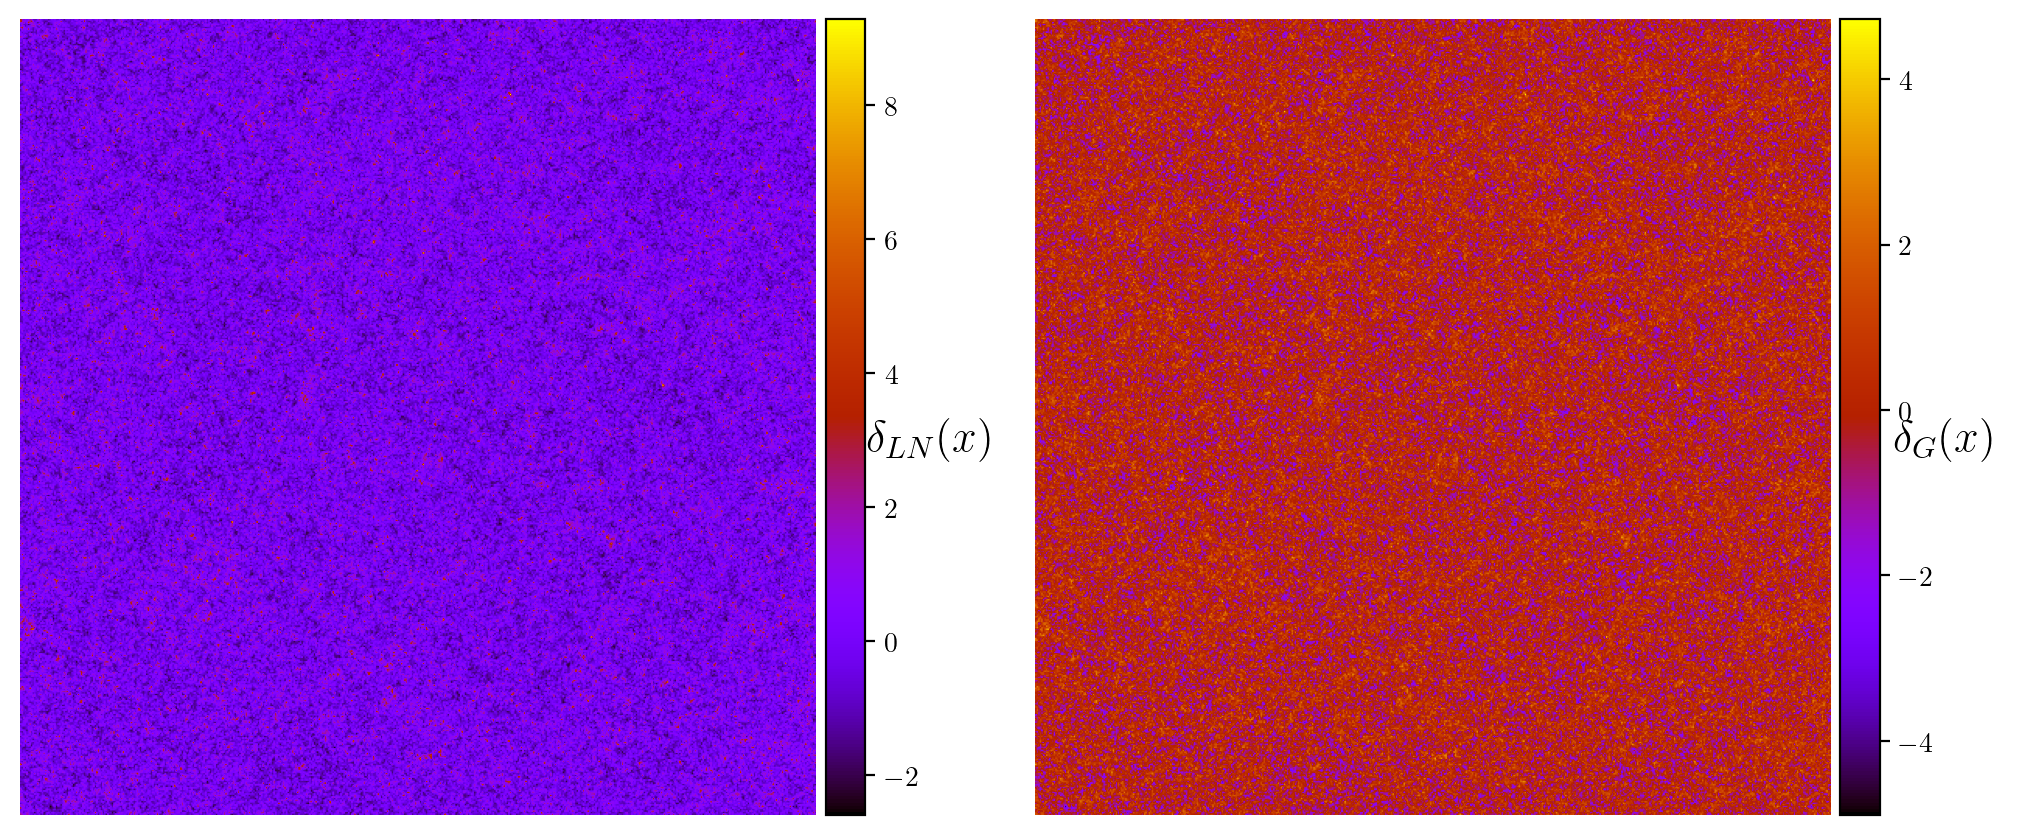

In [ ]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
from mpl_toolkits.axes_grid1 import make_axes_locatable


MIN = min(ln.min(), g.min())
MAX = max(ln.max(), g.max())

fig, axs = plt.subplots(1, 2, dpi=200, figsize=(12., 6.))
ax = axs[0]
# ln_ = (ln - ln.mean()) / ln.std()
im = ax.imshow(ln_.squeeze(), cmap="gnuplot", )#vmin=MIN, vmax=MAX)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical');
cbar.set_label(label="$\delta_{LN}(x)$", rotation=0, fontsize=16)
ax.axis("off")

ax = axs[1]
# g_ = (g - g.mean()) / g.std()
im = ax.imshow(g_.squeeze(), cmap="gnuplot", )#vmin=MIN, vmax=MAX)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical');
cbar.set_label(label="$\delta_G(x)$", rotation=0, fontsize=16)
ax.axis("off")

# plt.tight_layout()
plt.savefig("figs/" + "LN" if LN else "G" + "_field.pdf")
plt.show()

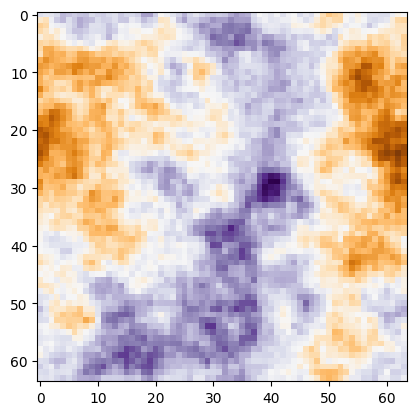

TypeError: Invalid shape (3, 64, 64, 33) for image data

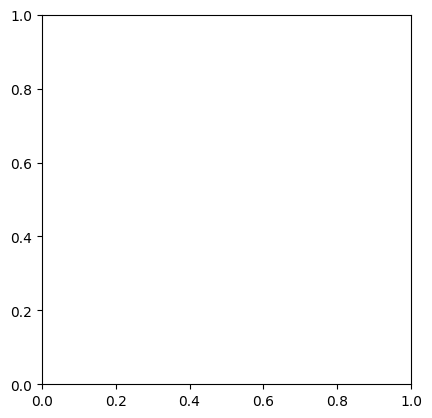

In [23]:
import jax
import jax.numpy as jnp 
import jax.random as jr 
import matplotlib.pyplot as plt

key = jr.PRNGKey(0)

def Pk_fn(k, parameters):
    A, B = parameters
    Pk = jnp.zeros_like(k)
    Pk = Pk.at[k > 0].set(A * k[k > 0] ** -B)
    return Pk

def simulator(key, parameters, n_pix):
    mu = jr.normal(key, shape=(n_pix, n_pix))
    muk = jnp.fft.rfftn(mu)

    kgrid = jnp.c_[
        jnp.meshgrid(
            *[jnp.fft.fftfreq(_) for _ in mu.shape[:-1]], 
            jnp.fft.rfftfreq(mu.shape[-1]), 
            indexing='ij'
        )
    ]
    k = jnp.linalg.norm(kgrid, axis=0)
    Pk = Pk_fn(k, parameters)

    deltak = muk * jnp.sqrt(Pk)
    delta = jnp.fft.irfftn(deltak)
    return delta

n_pix = 64

delta = simulator(key, jnp.array([4., 3.]), n_pix=n_pix)

plt.imshow(delta, cmap="PuOr")
plt.show()

# ddelta = jax.jacfwd(simulator, argnums=1)(key, jnp.array([4., 3.]), n_pix=n_pix)
# plt.imshow(ddelta[..., 0], cmap="PuOr")
# plt.show()
# plt.imshow(ddelta[..., 1], cmap="PuOr")
# plt.show()
# ddelta
kgrid = jnp.c_[
    jnp.meshgrid(
        *[jnp.fft.fftfreq(_) for _ in (n_pix, n_pix)], 
        jnp.fft.rfftfreq(n_pix), 
        indexing='ij'
    )
]
plt.imshow(kgrid)